# **<span style="font-family: 'Palatino Linotype', serif;"> 🌙💭🫧 Preciso de um espaço (latente) para pensar </span>**
----
*<span style="font-family: 'Angilla Tattoo'"> "Entre um feitiço e outro, Maga Patolina recolhia-se em mundos latentes, onde o pensamento fluía livre, longe do ruído da realidade." 🦆🧠🌿📜 </span>*



<div align="center">
    <img src = "Maga espaco.png" alt = "Magas pop" width = 250>
</div>

----
 **Objetivo:** Nesse notebook, iremos implementar uma rede neural do tipo autoenconder utilizando PyTorch e treiná-la com o banco de dados do MNSIT, de forma didática, explicando o que são o codificador, decodificador e o espaço latente.
 
 ----

### ❓ O que é o autoencoder?

O autoenconder é um tipo de rede neural, utilizada especialmente para redução de dimensionalidade (o que é útil para diminuir o tempo de processamento e favorecer a convergência do algoritmo), remoção de ruídos e detecção de anomalias. 

Essa é uma rede neural totalmente conectada, ou seja, todos os dados de entrada se conectam a um neurônio que se conecta a uma saída. 

<div align="center">
    <img src = "enconder.png" alt = "Autoenconder" width = 350>
</div>

O Enconder é a camada que recebe os dados de entrada da rede e sintetiza as principais informações destes. Em seguida, os dados são transferidos para um espaço latente, que possui menor dimensionalidade, e assim, será responsável por representar os dados de forma compacta. Na última etapa, o enconder irá recnstruir os dados já compactados. 

O tamanho do espaço latente está diretamente relacionado ao quanto os nossos dados serão compactados. Já o número de camadas e de neurônios por camada está relacionado a quantidade de informações e detalhes que serão absorvidas pelos dados. Mas cuidado, um número muito grande pode causar overfitting! 

O código apresentado foi adaptado da primeira referência.

In [53]:
pip install gdown

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:

import torch
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Deixa com 1 canal
    transforms.Resize((64, 64)),                 # Garante que é 64x64
    transforms.ToTensor()
])

# Tamanho do "lote" (parte que será computada)
batch_size = 64

# Baixando dados de treino
trainSet = torchvision.datasets.FakeData(size=1000, transform=transform)
trainLoader = torch.utils.data.DataLoader(dataset = trainSet, batch_size=batch_size, shuffle=True)

# Baixando dados de teste
testSet = torchvision.datasets.FakeData(size=200, transform=transform)
testLoader = torch.utils.data.DataLoader(dataset = testSet, batch_size=batch_size, shuffle=False)


In [55]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()

        # os dados irão passar por uma função linear e, em seguida, pela função ReLu
        # a dimensionalidade dos dados é alterada durante o processamento
        # ao final, os dados tem dimensionalidade de 64

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128), # essa linha diz: iremos recebr x dados de entrada, aplicar uma função linear, e devovler 128 dados de saída
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
        )

        # os dados são decodificados passando pelas mesmas funções, para obter os dados sintetizados
        # nesse caso, começa pela dimensionalidade baixa e cresce até o original
        # mantém a simetria da função
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_size),  # Reconstruct to 784
            nn.Tanh(),  # Use Tanh activation for pixel values in [-1, 1]
        )

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return decoder

In [56]:
import torch.optim as optim

# Define o tamanho dos daods que serão analisados, no caso imagens 64x64 pixels:
tamanho_entrada = 64 * 64 

# Define a taxa de aprendizado:
taxa_aprendizado = 0.01

# Faz o código rodar no GPU, se disponível:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instância da rede neural:
autoencoder = Autoencoder(tamanho_entrada).to(device)

# Função de perda:
funcao_perda = nn.MSELoss().to(device)

# Otimizador:
otimizador = optim.Adam(autoencoder.parameters(), lr = taxa_aprendizado)

In [57]:
num_epocas = 10

#Treinando o modelo 
autoencoder.train()

for epoca in range(num_epocas):

    perda_inicial = 0.0

    for data in trainLoader:

        # Selecionando dados a serem processados 
        inputs, _ = data

        # Altera o formato dos dados para uma linha
        inputs = inputs.view(inputs.size(0), -1) 

        # Passa os dados com formato de linha para a GPU
        inputs = inputs.to(device)

        # Zera os gradientes
        otimizador.zero_grad()

        # Passa os dados pelo autoenconder, usando a instância que definimos
        outputs = autoencoder(inputs)

        # Calcula a perda
        loss = funcao_perda(outputs, inputs)

        # Calcula a perda da época
        perda_inicial += loss.item()

        # Calcula a função de perda dos gradientes
        loss.backward()

        # Atualiza os gradientes otimizados do modelo
        otimizador.step()

    print('época:', epoca+1, '/', num_epocas, 'Perda', perda_inicial)

época: 1 / 10 Perda 0.9538887022063136
época: 2 / 10 Perda 0.0348424349213019
época: 3 / 10 Perda 0.024057169328443706
época: 4 / 10 Perda 0.022441431530751288
época: 5 / 10 Perda 0.02211275848094374
época: 6 / 10 Perda 0.02206314366776496
época: 7 / 10 Perda 0.02583879348821938
época: 8 / 10 Perda 0.023195768240839243
época: 9 / 10 Perda 0.022270965622738004
época: 10 / 10 Perda 0.022122295456938446


In [58]:
imagens_originais = []
imagens_reconstruidas = []

# modelo entra no modo de teste
autoencoder.eval()

# passa pelo teste com os dados selecionados
for data in testLoader:
    inputs, _ = data
    inputs = inputs.view(inputs.size(0), -1)
    inputs = inputs.to(device)  # mesmo processo de mudar o formato dos dados e passar para GPU

    # Forward pass 
    with torch.no_grad():  # para de calcular os gradientes
        outputs = autoencoder(inputs) # dados de teste passam pela rede autoenconder já definida
    
    # dados voltam para CPU para visualização
    imagens_originais.append(inputs.cpu())  
    imagens_reconstruidas.append(outputs.cpu())
    
# Combina os "lotes" de imagens em tensores 
imagens_originais = torch.cat(imagens_originais, dim=0)
imagens_reconstruidas = torch.cat(imagens_reconstruidas, dim=0)

# Converte os tensores em arrays numpy
imagens_originais = imagens_originais.numpy()
imagens_reconstruidas = imagens_reconstruidas.numpy()

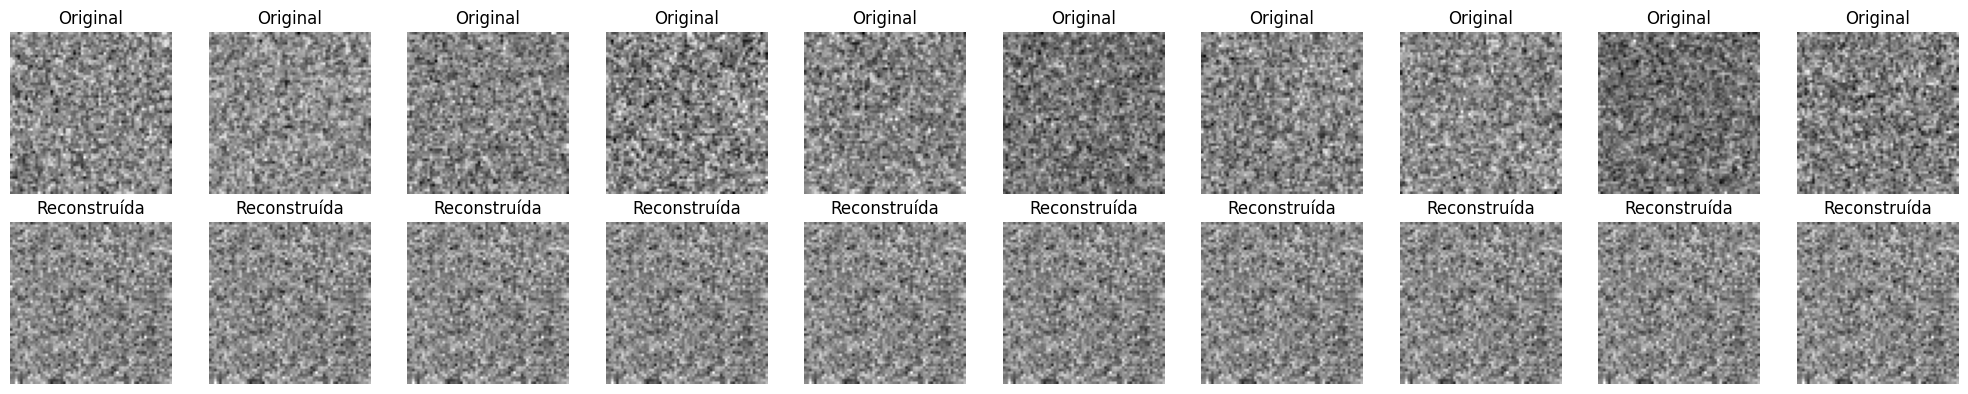

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Quantas imagens você quer mostrar
num_imagens = 10  

# Configura o tamanho do gráfico
plt.figure(figsize=(20, 4))

for i in range(num_imagens):
    # Exibe imagem original
    ax = plt.subplot(2, num_imagens, i + 1)
    plt.imshow(imagens_originais[i].reshape(64, 64), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Exibe imagem reconstruída
    ax = plt.subplot(2, num_imagens, i + 1 + num_imagens)
    plt.imshow(imagens_reconstruidas[i].reshape(64, 64), cmap="gray")
    plt.title("Reconstruída")
    plt.axis("off")

plt.tight_layout()
plt.show()


-----

### 📊 Conclusão:

Nesse notebook, exploramos as redes neurais autoenconder. Foi possível perceber que essas redes são úteis para diminuir a dimensionalidade dos dados e facilitar o processamento, otimiazando o processamento de dados e diminuindo o gasto computacional. Sua implementação por pytorch é semelhante a de outras rede neurais já estudadas. Os resultados obtidos foram satisfatórios e mostram a eficiência e aplicabilidade dessa rede em problemas reais. 

----
### 📚 Referências:

1. UTINO, Matheus. Autoencoder: entendendo e implementando com facilidade. Medium, 2020. Disponível em: <https://medium.com/@matheusutino/autoencoder-entendendo-e-implementando-com-facilidade-e9c042fa9976>. Acesso em: 27 abr. 2025.

2. GOOGLE COLAB. Autoencoder. Disponível em: <https://colab.research.google.com/drive/1sZJhyCWyEEGtLTZmFlnSvvW76hEEhltu?usp=sharing#scrollTo=nHw2T5fqzNt8>. Acesso em: 27 abr. 2025.


3. Introdução aos Autoencoders. Deep Learning Book. Disponível em: <https://www.deeplearningbook.com.br/introducao-aos-autoencoders/>. Acesso em: 27 abr. 2025.

4. KANARIES. Python - nn-linear. Disponível em: <https://docs.kanaries.net/pt/topics/Python/nn-linear>. Acesso em: 27 abr. 2025.

4. OPENAI. ChatGPT. 2025. Disponível em: <https://chatgpt.com/share/680e91ad-4c34-8005-906c-2a282c25852b>. Acesso em: 27 abr. 2025.